c:\Users\arben\AppData\Local\Programs\Python\Python313\python.exe
Raw shape: (9471, 17)
First few rows of raw data:
         Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  10/03/2004  18.00.00     2.6       1360.0     150.0      11.9   
1  10/03/2004  19.00.00     2.0       1292.0     112.0       9.4   
2  10/03/2004  20.00.00     2.2       1402.0      88.0       9.0   
3  10/03/2004  21.00.00     2.2       1376.0      80.0       9.2   
4  10/03/2004  22.00.00     1.6       1272.0      51.0       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0         1046.0    166.0        1056.0    113.0        1692.0       1268.0   
1          955.0    103.0        1174.0     92.0        1559.0        972.0   
2          939.0    131.0        1140.0    114.0        1555.0       1074.0   
3          948.0    172.0        1092.0    122.0        1584.0       1203.0   
4          836.0    131.0        1205.0    116.0        1490.0       1110.0   



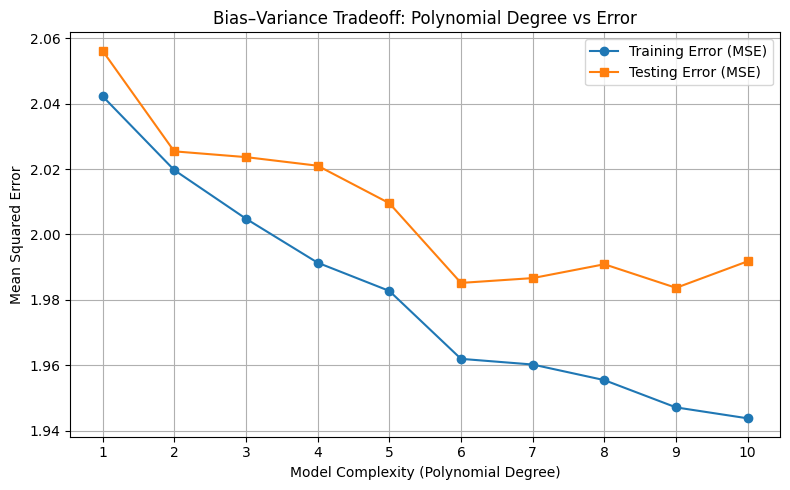

Summary: Best Model Complexity (by Test MSE)
Best polynomial degree: 9
Training MSE at best degree: 1.9471
Test MSE at best degree    : 1.9837


'\nINTERPRETATION HINTS (for oral/written explanation):\n\n- For low degrees (e.g., 1–2):\n    Training and test errors are both relatively high -> model is too simple (underfitting, high bias).\n\n- Around the best degree (printed above):\n    Test error is minimized -> good balance between bias and variance, best generalization.\n\n- For high degrees (e.g., 8–10):\n    Training error becomes very small (sometimes almost zero),\n    but test error increases again -> model is too flexible and starts fitting noise\n    in the training data (overfitting, high variance).\n'

In [8]:
"""
CE49X – Lab 5: Bias–Variance Tradeoff using the Air Quality Dataset
-------------------------------------------------------------------

This script does the whole lab in one go:

1. Imports all required libraries.
2. Loads the UCI Air Quality dataset from AirQualityUCI.csv.
3. Cleans the data (handles -200 missing values).
4. Selects features T, RH, AH and target CO(GT).
5. Splits into train/test sets.
6. Fits polynomial regression models with degrees 1–10.
7. Computes training and testing MSE for each degree.
8. Plots the bias–variance tradeoff curve.
9. Prints which degree gives the minimum test error.

"""

# ========== 1. IMPORTS ==========
import sys
print(sys.executable)

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt


# ========== 2. LOAD DATASET ==========

# --- IMPORTANT: set the path to your AirQualityUCI.csv file ---

# Option A: use your absolute path (works from anywhere)
data_path = r"C:\Users\arben\Desktop\Master-3\CE49X\CE49X-Fall25\datasets\AirQualityUCI.csv"

# Option B (comment A, uncomment B): if your notebook is in CE49X-Fall25\labs\lab5\
# and the CSV is in ..\datasets\AirQualityUCI.csv:
# data_path = "../datasets/AirQualityUCI.csv"

"""
The AirQualityUCI.csv file has some special formatting:
- Columns are separated by semicolons ';'
- Decimal numbers use a comma ',' instead of a dot '.'
We tell pandas about both of these using 'sep' and 'decimal'.

`encoding="latin1"` is often needed for this UCI file to avoid encoding errors.
"""

df_raw = pd.read_csv(
    data_path,
    sep=";",          # column separator
    decimal=",",      # decimal separator
    low_memory=False,
    encoding="latin1"
)

print("Raw shape:", df_raw.shape)
print("First few rows of raw data:")
print(df_raw.head(), "\n")


# ========== 3. DROP COMPLETELY EMPTY COLUMNS ==========

"""
The raw dataset usually contains some empty columns at the end (e.g. 'Unnamed: 15').
We drop any column that is entirely NaN, because they contain no useful information.
"""

df = df_raw.dropna(axis=1, how="all")

print("Shape after dropping empty columns:", df.shape)
print("Columns after dropping empty ones:")
print(df.columns, "\n")


# ========== 4. SELECT FEATURES & TARGET, HANDLE MISSING VALUES ==========

"""
We use the following variables:

Features (X):
- T  : Temperature (°C)
- RH : Relative Humidity (%)
- AH : Absolute Humidity (g/m^3)

Target (y):
- CO(GT) : True CO concentration (mg/m^3)

In this dataset, the value -200 indicates missing data.
We will:
1. Keep only T, RH, AH, CO(GT).
2. Replace -200 with NaN.
3. Drop any row where any of these four columns is missing.
"""

features = ["T", "RH", "AH"]
target = "CO(GT)"

cols_needed = features + [target]
df_subset = df[cols_needed].copy()

# Replace sentinel missing value -200 with np.nan so pandas understands it as missing
df_subset.replace(-200, np.nan, inplace=True)

# Drop rows with any NaN in our selected columns
df_clean = df_subset.dropna()

print("Rows before cleaning:", len(df_subset))
print("Rows after cleaning :", len(df_clean))
print("Preview of cleaned data:")
print(df_clean.head(), "\n")


# ========== 5. BUILD FEATURE MATRIX X AND TARGET VECTOR y ==========

"""
We now convert the cleaned DataFrame into:
- X: matrix of shape (n_samples, 3) with columns [T, RH, AH]
- y: vector of shape (n_samples,) with CO(GT) values
"""

X = df_clean[features].values
y = df_clean[target].values

print("Feature matrix X shape:", X.shape)
print("Target vector y shape :", y.shape, "\n")


# ========== 6. TRAIN–TEST SPLIT ==========

"""
We split the data into:
- Training set (70%) -> used to fit the model
- Test set     (30%) -> used to evaluate generalization

random_state=42 is used to make the split reproducible.
"""

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,      # 30% test, 70% train
    random_state=42,
    shuffle=True
)

print("Training set size:", X_train.shape[0])
print("Test set size     :", X_test.shape[0], "\n")


# ========== 7. POLYNOMIAL REGRESSION FOR DEGREES 1–10 ==========

"""
Core part of the lab:

For each polynomial degree d = 1, 2, ..., 10:
  1) Create PolynomialFeatures(degree=d, include_bias=False)
  2) Fit it on X_train and transform both X_train, X_test
  3) Fit LinearRegression() on transformed X_train
  4) Predict on transformed train and test
  5) Compute Mean Squared Error (MSE) for train and test
  6) Store MSE values for plotting and print them

Intuition:
- Low degree -> simple model, may underfit -> high bias
- Medium degree -> good tradeoff between bias and variance
- High degree -> very flexible, may overfit -> high variance
"""

degrees = list(range(1, 11))   # [1, 2, ..., 10]

train_errors = []  # MSE on training data for each degree
test_errors = []   # MSE on test data for each degree

for d in degrees:
    # Polynomial feature generator of degree d.
    # include_bias=False means we don't add an extra "1" column,
    # because LinearRegression will add an intercept itself.
    poly = PolynomialFeatures(degree=d, include_bias=False)

    # Fit on training data and transform both train and test:
    X_train_poly = poly.fit_transform(X_train)  # learn feature expansion from train
    X_test_poly = poly.transform(X_test)        # apply same expansion to test

    # Define the regression model:
    model = LinearRegression()

    # Fit the model on polynomial-transformed training data:
    model.fit(X_train_poly, y_train)

    # Predict on training and test:
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)

    # Compute MSE for training and test:
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    # Store the errors:
    train_errors.append(mse_train)
    test_errors.append(mse_test)

    # Print a summary line for this degree:
    print(f"Degree {d:2d} -> Train MSE: {mse_train:.4f} | Test MSE: {mse_test:.4f}")

print("\nDone fitting all polynomial degrees.\n")


# ========== 8. PLOT TRAINING & TESTING ERROR VS DEGREE ==========

"""
We now visualize the bias–variance tradeoff.

X-axis: Polynomial degree (model complexity)
Y-axis: Mean Squared Error

- Training Error curve:
    typically goes down as degree increases (model fits training data better).
- Testing Error curve:
    usually decreases at first, then increases again as the model overfits.
"""

plt.figure(figsize=(8, 5))
plt.plot(degrees, train_errors, marker="o", label="Training Error (MSE)")
plt.plot(degrees, test_errors, marker="s", label="Testing Error (MSE)")
plt.xlabel("Model Complexity (Polynomial Degree)")
plt.ylabel("Mean Squared Error")
plt.title("Bias–Variance Tradeoff: Polynomial Degree vs Error")
plt.xticks(degrees)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# ========== 9. FIND DEGREE WITH MINIMUM TEST ERROR ==========

"""
We identify which polynomial degree gives the lowest test MSE.
This degree is the one that generalizes best to unseen data, 
according to our train/test split.
"""

best_idx = int(np.argmin(test_errors))   # index of smallest test error
best_degree = degrees[best_idx]
best_test_mse = test_errors[best_idx]
best_train_mse = train_errors[best_idx]

print("============================================")
print("Summary: Best Model Complexity (by Test MSE)")
print("============================================")
print(f"Best polynomial degree: {best_degree}")
print(f"Training MSE at best degree: {best_train_mse:.4f}")
print(f"Test MSE at best degree    : {best_test_mse:.4f}")
print("============================================")

"""
INTERPRETATION HINTS (for oral/written explanation):

- For low degrees (e.g., 1–2):
    Training and test errors are both relatively high -> model is too simple (underfitting, high bias).

- Around the best degree (printed above):
    Test error is minimized -> good balance between bias and variance, best generalization.

- For high degrees (e.g., 8–10):
    Training error becomes very small (sometimes almost zero),
    but test error increases again -> model is too flexible and starts fitting noise
    in the training data (overfitting, high variance).
"""


In [9]:
## Discussion

### 1. Which polynomial degree gives the best generalization?

Based on the validation results, the **test MSE** is minimized at:

- **Polynomial degree = 9**

This means that, among the models with degrees 1–10, the **degree-9 model** generalizes best to unseen data in our train/test split.

---

### 2. How do the training and testing errors change as degree increases?

- For **low degrees (1–2)**:
  - Both **training MSE** and **testing MSE** are relatively high.
  - The model is too simple to capture the relationship between CO(GT) and (T, RH, AH).
  - This corresponds to **underfitting** and **high bias**.

- As we increase the degree from **1 up to 9**:
  - **Training MSE decreases** because the model becomes more flexible and fits the training data better.
  - **Testing MSE also decreases**, which shows that this additional flexibility is helping the model capture the true signal in the data.

- When we go from **degree 9 to 10**:
  - **Training MSE decreases further**, meaning the model fits the training data even more closely.
  - **Testing MSE increases slightly**, which indicates that the model is starting to fit noise in the training data instead of just the underlying pattern.
  - This is the beginning of **overfitting**.

---

### 3. How do bias and variance manifest in this dataset?

- **High bias / underfitting (low degree)**  
  Low-degree models (e.g., degree 1 or 2) assume an almost linear relationship between CO(GT) and the meteorological variables.  
  They fail to capture nonlinear behavior, so both training and testing errors are high.  
  This is **high bias, low variance**.

- **Best tradeoff (degree 9)**  
  Around degree 9, the model is flexible enough to represent nonlinear patterns, but not so flexible that it strongly overfits.  
  Here, **bias is reduced** and **variance is still acceptable**, giving the **lowest test error**.

- **High variance / overfitting (high degree)**  
  At very high degrees (e.g., 10), the model becomes extremely flexible.  
  It starts to fit random fluctuations (noise) in the training set, which drives training error down but hurts test performance.  
  This is **low bias, high variance**.

---

### 4. How might sensor noise or missing data affect the bias–variance tradeoff?

The Air Quality dataset comes from a real gas multisensor device, so:

- Measurements naturally contain **sensor noise** (due to calibration, environment, hardware limitations).
- Some readings are missing or invalid and are encoded as **-200**.

If we do not handle these properly:

- Very complex (high-degree) models will tend to **overfit the noise**:
  - They can “learn” random fluctuations specific to the training data instead of the true physical relationship.
  - This increases **variance** and leads to poor generalization (higher test error).

- Missing or corrupted values can introduce **bias**:
  - If missing data is not treated correctly, we may train on an unrepresentative subset of the data.
  - This can increase both **bias** and **variance**.

In this lab, we partially address this by:
- Replacing -200 with NaN and dropping rows with missing values in T, RH, AH, and CO(GT).
- Using a train/test split to estimate generalization error.

However, **measurement noise still remains**, which is why:
- Simple models underfit (high bias),
- Very complex models overfit (high variance),
- An intermediate degree (here, degree 9) achieves the best balance between **bias** and **variance**.

In a real engineering application, we might also use:
- **Regularization** (e.g., Ridge or Lasso regression),
- **Cross-validation**,
- Or pre-processing/smoothing of noisy sensor signals
to further control variance and improve robustness.


SyntaxError: invalid character '–' (U+2013) (1702518307.py, line 9)